# FireWatch 2024: Incêndios florestais e seca no Brasil


Discente: Cleidiana Manoel Alves

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
!pip install geobr --quiet

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from geobr import read_state

## Carregando dados



In [139]:
# Arquivos com cada quadrimestre

df1 = pd.read_csv('/content/Dataset_FireWatch_Brazil_Q1_2024.csv')
df2 = pd.read_csv('/content/Dataset_FireWatch_Brazil_Q2_2024.csv')
df3 = pd.read_csv('/content/Dataset_FireWatch_Brazil_Q3_2024.csv')
df4 = pd.read_csv('/content/Dataset_FireWatch_Brazil_Q4_2024.csv')

In [140]:
# Conferindo os dados

df1.head(), df1.info(),
df2.head(), df2.info(),
df3.head(), df3.info(),
df4.head(), df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43753 entries, 0 to 43752
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       43753 non-null  object 
 1   municipio                  43753 non-null  object 
 2   estado                     43753 non-null  object 
 3   bioma                      43752 non-null  object 
 4   avg_numero_dias_sem_chuva  43753 non-null  float64
 5   avg_precipitacao           43753 non-null  float64
 6   avg_risco_fogo             43753 non-null  float64
 7   avg_frp                    43753 non-null  float64
dtypes: float64(4), object(4)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48979 entries, 0 to 48978
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       48979 non-null  object 
 1  

(         data              municipio    estado     bioma  \
 0  2024-10-01     CANDEIAS DO JAMARI  RONDÔNIA  Amazônia   
 1  2024-10-01                VILHENA  RONDÔNIA  Amazônia   
 2  2024-10-01                VILHENA  RONDÔNIA   Cerrado   
 3  2024-10-01                 CACOAL  RONDÔNIA  Amazônia   
 4  2024-10-01  SÃO MIGUEL DO GUAPORÉ  RONDÔNIA  Amazônia   
 
    avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  avg_frp  
 0                       0.27             12.87            9.44   332.87  
 1                       1.57             48.43           83.86    58.57  
 2                       0.00              0.00           63.00   741.00  
 3                       1.00              0.00            0.00     4.67  
 4                       0.00             24.00           91.70    19.70  ,
 None)

In [141]:
# Concatenando os dados

df = pd.concat([df1, df2, df3, df4 ], ignore_index=True)

In [142]:
# Verificando duplicatas

df.duplicated().sum()

np.int64(0)

## Conhecendo os dados


In [143]:
df.head()



,data,municipio,estado,bioma,avg_numero_dias_sem_chuva,avg_precipitacao,avg_risco_fogo,avg_frp
0,2024-01-01,VALE DO ANARI,RONDÔNIA,Amazônia,0.0,1698.00,0.0,13.00
1,2024-01-01,SÃO GABRIEL DA CACHOEIRA,AMAZONAS,Amazônia,0.2,206.80,0.0,81.40
2,2024-01-01,MANAQUIRI,AMAZONAS,Amazônia,0.0,60.00,0.0,27.00
3,2024-01-01,JUTAÍ,AMAZONAS,Amazônia,2.0,776.00,0.0,211.00
4,2024-01-01,AUTAZES,AMAZONAS,Amazônia,0.0,2.22,0.0,97.67


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281016 entries, 0 to 281015
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   data                       281016 non-null  object 
 1   municipio                  281016 non-null  object 
 2   estado                     281016 non-null  object 
 3   bioma                      281015 non-null  object 
 4   avg_numero_dias_sem_chuva  281016 non-null  float64
 5   avg_precipitacao           281016 non-null  float64
 6   avg_risco_fogo             281016 non-null  float64
 7   avg_frp                    280736 non-null  float64
dtypes: float64(4), object(4)
memory usage: 17.2+ MB


In [145]:
df.shape


(281016, 8)

In [146]:
df.describe(), df.isnull().sum()

(       avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  \
 count              281016.000000     281016.000000   281016.000000   
 mean                   20.186295        131.261737       54.701241   
 std                    30.464316       1423.569911      119.227718   
 min                     0.000000          0.000000     -999.000000   
 25%                     1.000000          0.000000        2.000000   
 50%                     6.000000          0.000000       61.170000   
 75%                    24.000000          2.000000      100.000000   
 max                   120.000000     268104.500000     4999.500000   
 
              avg_frp  
 count  280736.000000  
 mean     3548.242808  
 std     11354.944712  
 min    -50830.000000  
 25%        37.200000  
 50%        74.290000  
 75%       195.370000  
 max     45914.000000  ,
 data                           0
 municipio                      0
 estado                         0
 bioma                          1
 avg_n

## Tratamento dos dados

Para garantir a qualidade dos dados, realizei as seguintes etapas de tratamento:

- Preenchimento de valores ausentes nas colunas numéricas com a mediana.
- Preenchimento de valores ausentes em colunas categóricas, como biomas, usando a moda.
- Verificação de possíveis outliers e normalização dos dados para realizar a análise.
- Substituir tipo object para datetime em 'data'


In [147]:
df_clean = df.copy()


df_clean['avg_frp'].fillna(df_clean['avg_frp'].median(), inplace=True)

df_clean['bioma'].fillna(df_clean['bioma'].mode()[0], inplace=True)


print(df_clean.isnull().sum())

data                         0
municipio                    0
estado                       0
bioma                        0
avg_numero_dias_sem_chuva    0
avg_precipitacao             0
avg_risco_fogo               0
avg_frp                      0
dtype: int64


/tmp/ipython-input-147-2981393638.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['avg_frp'].fillna(df_clean['avg_frp'].median(), inplace=True)
/tmp/ipython-input-147-2981393638.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [148]:
# Object para datatime

df_clean['data'] = pd.to_datetime(df_clean['data'], format='%Y-%m-%d', errors='coerce')

# Verificar o resultado
print(df_clean['data'].head())

0   2024-01-01
1   2024-01-01
2   2024-01-01
3   2024-01-01
4   2024-01-01
Name: data, dtype: datetime64[ns]


In [149]:
df_clean.info(), df_clean.shape, df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281016 entries, 0 to 281015
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   data                       281016 non-null  datetime64[ns]
 1   municipio                  281016 non-null  object        
 2   estado                     281016 non-null  object        
 3   bioma                      281016 non-null  object        
 4   avg_numero_dias_sem_chuva  281016 non-null  float64       
 5   avg_precipitacao           281016 non-null  float64       
 6   avg_risco_fogo             281016 non-null  float64       
 7   avg_frp                    281016 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 17.2+ MB


(None,
 (281016, 8),
         data                 municipio    estado     bioma  \
 0 2024-01-01             VALE DO ANARI  RONDÔNIA  Amazônia   
 1 2024-01-01  SÃO GABRIEL DA CACHOEIRA  AMAZONAS  Amazônia   
 2 2024-01-01                 MANAQUIRI  AMAZONAS  Amazônia   
 3 2024-01-01                     JUTAÍ  AMAZONAS  Amazônia   
 4 2024-01-01                   AUTAZES  AMAZONAS  Amazônia   
 
    avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  avg_frp  
 0                        0.0           1698.00             0.0    13.00  
 1                        0.2            206.80             0.0    81.40  
 2                        0.0             60.00             0.0    27.00  
 3                        2.0            776.00             0.0   211.00  
 4                        0.0              2.22             0.0    97.67  )

**Problema 1: Quais estados apresentaram maior risco médio de queimadas em 2024?**

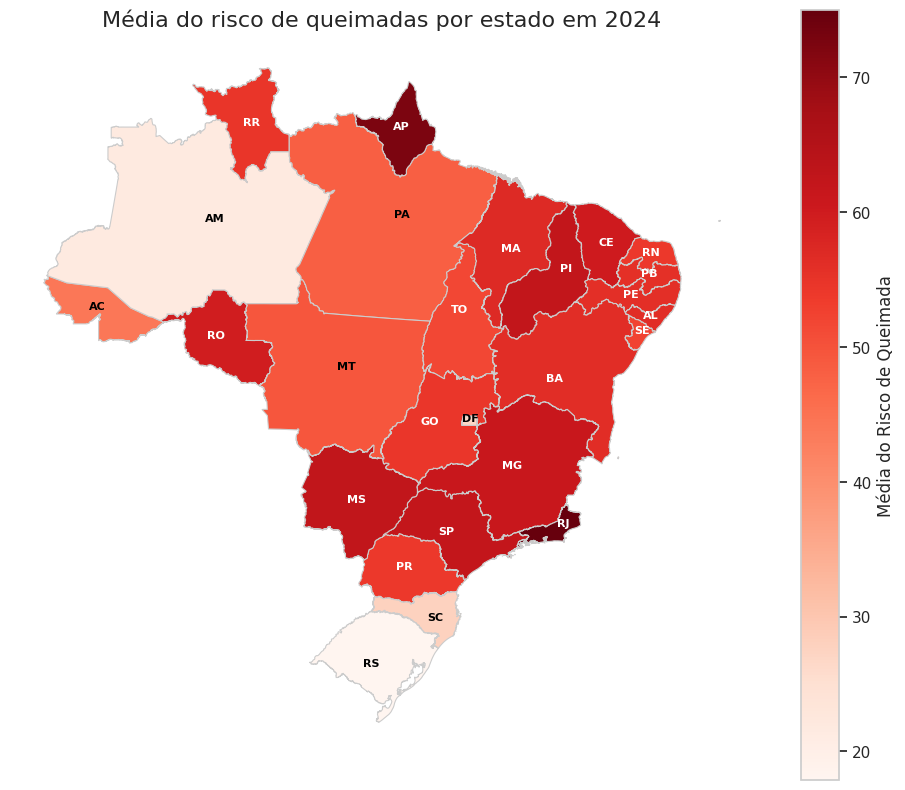

In [150]:
risco_estado = df.groupby("estado")["avg_risco_fogo"].mean().reset_index()
risco_estado["estado"] = risco_estado["estado"].str.title()

estados = read_state()
estados["sigla"] = estados["abbrev_state"]
mapa = estados.merge(risco_estado, left_on="name_state", right_on="estado")

fig, ax = plt.subplots(figsize=(12, 10))
mapa.plot(column="avg_risco_fogo", cmap="Reds", linewidth=0.8,
          edgecolor='0.8', legend=True, ax=ax,
          legend_kwds={"label": "Média do Risco de Queimada"})

for idx, row in mapa.iterrows():
    ponto = row.geometry.representative_point()
    cor_texto = 'white' if row["avg_risco_fogo"] > 50 else 'black'
    plt.text(ponto.x,
             ponto.y,
             row["sigla"],
             ha='center', fontsize=8, fontweight='bold', color=cor_texto)

ax.set_title("Média do risco de queimadas por estado em 2024", fontsize=16)
ax.axis('off')
plt.show()

O gráfico de mapa evidencia que os estados das regiões Sudeste, Centro-Oeste e Norte concentram os maiores riscos médios de queimadas em 2024, com destaque para Amapá, Mato Grosso do Sul, Minas Gerais e Rio de Janeiro.

**Problema 2: Como o risco médio de queimadas variou ao longo do ano de 2024 em cada bioma brasileiro?**

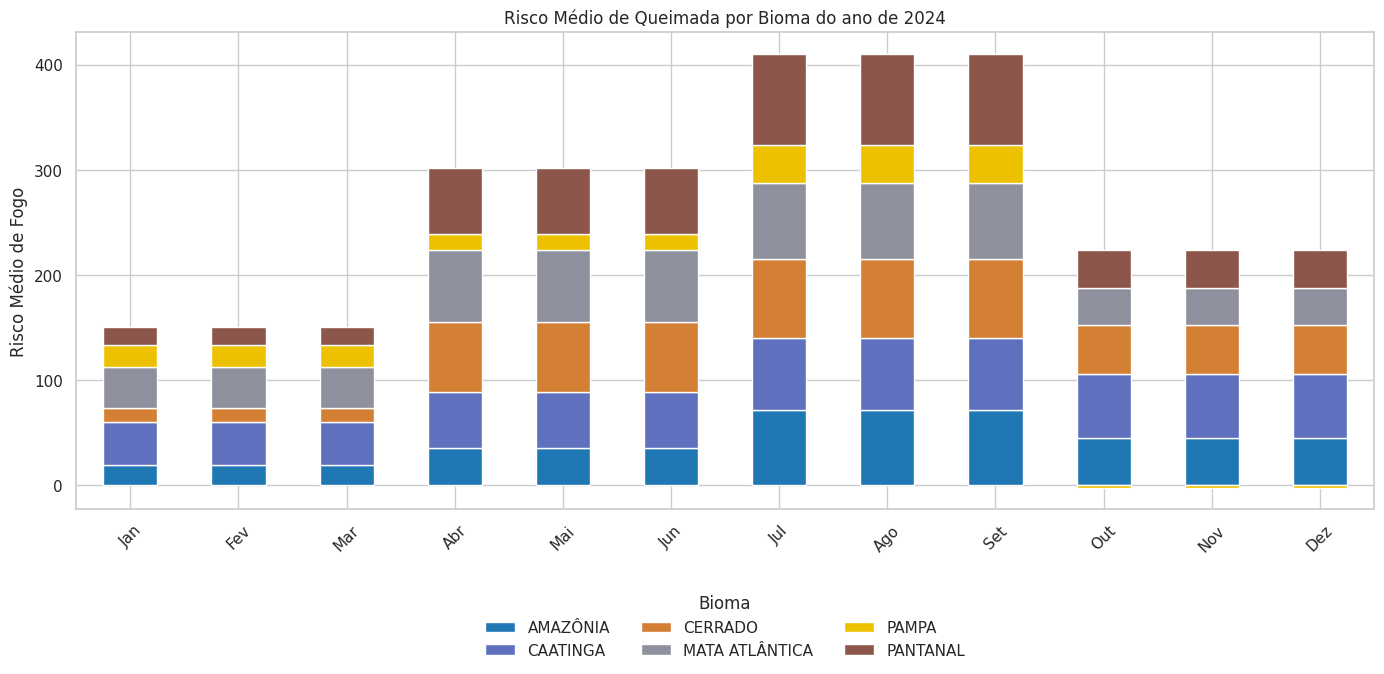

In [154]:
trimestres = [
    (df1, ['Jan', 'Fev', 'Mar']),
    (df2, ['Abr', 'Mai', 'Jun']),
    (df3, ['Jul', 'Ago', 'Set']),
    (df4, ['Out', 'Nov', 'Dez'])
]

dados = []

for df, meses in trimestres:
    df['bioma'] = df['bioma'].str.strip().str.upper()
    media = df.groupby('bioma')['avg_risco_fogo'].mean()
    for mes in meses:
        temp = media.copy().reset_index()
        temp['mes'] = mes
        dados.append(temp)

df_final = pd.concat(dados)
tabela = df_final.pivot(index='mes', columns='bioma', values='avg_risco_fogo').fillna(0)

ordem_meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
tabela = tabela.reindex(ordem_meses)

cores = {
    'AMAZÔNIA': '#1f77b4',
    'CAATINGA': '#5f70bf',
    'CERRADO': '#d48034',
    'MATA ATLÂNTICA': '#8f909e',
    'PAMPA': '#edc100',
    'PANTANAL': '#8c564b'
}

fig, ax = plt.subplots(figsize=(14, 7))
tabela.plot(kind='bar', stacked=True, color=[cores[c] for c in tabela.columns], ax=ax)

ax.set_title('Risco Médio de Queimada por Bioma do ano de 2024')
ax.set_ylabel('Risco Médio de Fogo')
ax.set_xlabel('')
ax.legend(title='Bioma', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


O grafíco de barras empilhadas mostra que os meses de julho, agosto e setembro concentram os maiores riscos de queimadas em 2024, evidenciando um padrão sazonal. Biomas como Cerrado, Pantanal e Mata Atlântica se destacam como os mais afetados nesse período.

**Problema 3: Qual é a distribuição do número médio de dias sem chuva nas regiões analisadas?**

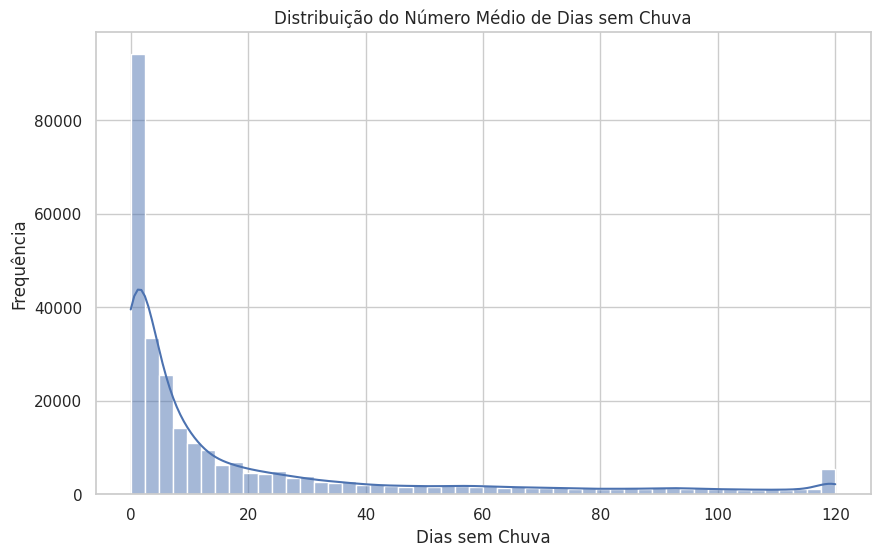

In [158]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['avg_numero_dias_sem_chuva'], bins=50, kde=True)
plt.title('Distribuição do Número Médio de Dias sem Chuva')
plt.xlabel('Dias sem Chuva')
plt.ylabel('Frequência')
plt.show()

Problema 4: Quais biomas apresentaram maior precipitação média por trimestre em 2024?

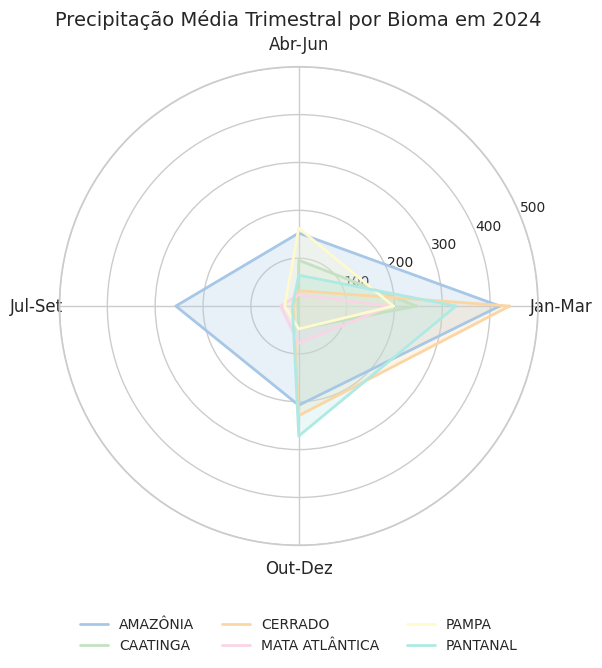

In [166]:
for df in [df1, df2, df3, df4]:
    df['bioma'] = df['bioma'].str.strip().str.upper()

q1 = df1.groupby('bioma')['avg_precipitacao'].mean().reset_index().rename(columns={'avg_precipitacao': 'Jan-Mar'})
q2 = df2.groupby('bioma')['avg_precipitacao'].mean().reset_index().rename(columns={'avg_precipitacao': 'Abr-Jun'})
q3 = df3.groupby('bioma')['avg_precipitacao'].mean().reset_index().rename(columns={'avg_precipitacao': 'Jul-Set'})
q4 = df4.groupby('bioma')['avg_precipitacao'].mean().reset_index().rename(columns={'avg_precipitacao': 'Out-Dez'})

df_merge = q1.merge(q2, on='bioma').merge(q3, on='bioma').merge(q4, on='bioma')
df_merge = df_merge.set_index('bioma')

labels = df_merge.index.tolist()
metrics = ['Jan-Mar', 'Abr-Jun', 'Jul-Set', 'Out-Dez']
values = df_merge.values

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

cores_pastel = ['#A7C7E7', '#C4E1C1', '#FAD6A5', '#F9D5E5', '#FFFACD', '#AFE9E3', '#F7B7A3']

fig, ax = plt.subplots(figsize=(9, 7), subplot_kw=dict(polar=True))

for i, row in enumerate(values):
    data = np.append(row, row[0])
    ax.plot(angles, data, label=labels[i], linewidth=2, color=cores_pastel[i % len(cores_pastel)])
    ax.fill(angles, data, color=cores_pastel[i % len(cores_pastel)], alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=metrics, fontsize=12)
ax.set_title("Precipitação Média Trimestral por Bioma em 2024", fontsize=14, pad=30)
ax.set_yticks([100, 200, 300, 400, 500])
ax.set_yticklabels(['100', '200', '300', '400', '500'], fontsize=10)
ax.set_ylim(0, 500)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

A análise do gráfico revela que o bioma Cerrado apresenta a maior precipitação média no primeiro trimestre (Jan-Mar), superando todos os outros biomas nesse período. A Amazônia mantém uma média elevada e mais constante ao longo do ano, evidenciando sua característica de alta umidade. O Pantanal se destaca no terceiro trimestre (Jul-Set), indicando um pico de chuvas que não ocorre nos demais biomas nesse mesmo período. Já a Caatinga e o Pampa apresentam os menores índices de precipitação média durante todos os trimestres, especialmente entre Out-Dez, o que reforça suas características de clima mais seco.